In [12]:
library(data.table) #pacote para importar base
library(tidyverse)  #pacote para manipular dados
library(janitor)    #pacote para padronizar nome das colunas
library(DescTools)  #
library(corrplot)   #cria "gráfico" matriz correlação
library(e1071)      #pacote com função para montar modelo Svm
library(caTools)    #
library(clusterGeneration) #pacote para separar base em teste e treino
library(caret)             #pacote com algoritmos de machine learnign
library(knitr) 
library(randomForest)
library(DMwR)

In [13]:
#importando base:
setwd("~/../Desktop/Pastas_Ds/Adult_Income/")
df = fread("adult.csv",stringsAsFactors = T,header = T)

setnames(df,"income","target")

names(df) = str_replace(names(df),"-","_")

In [14]:
head(df)

age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per-week,native_country,target
25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


In [15]:
#verificando se existem Na's na base:
df %>% 
  summarise_all(funs(sum(is.na(.))))

age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per-week,native_country,target
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
#apagando coluna native country
df$native_country = NULL

In [17]:
#verificando levels por fator:
df %>%
  select_if(is.factor) %>% 
  sapply(levels)


$workclass
[1] "?"                "Federal-gov"      "Local-gov"        "Never-worked"    
[5] "Private"          "Self-emp-inc"     "Self-emp-not-inc" "State-gov"       
[9] "Without-pay"     

$education
 [1] "10th"         "11th"         "12th"         "1st-4th"      "5th-6th"     
 [6] "7th-8th"      "9th"          "Assoc-acdm"   "Assoc-voc"    "Bachelors"   
[11] "Doctorate"    "HS-grad"      "Masters"      "Preschool"    "Prof-school" 
[16] "Some-college"

$marital_status
[1] "Divorced"              "Married-AF-spouse"     "Married-civ-spouse"   
[4] "Married-spouse-absent" "Never-married"         "Separated"            
[7] "Widowed"              

$occupation
 [1] "?"                 "Adm-clerical"      "Armed-Forces"     
 [4] "Craft-repair"      "Exec-managerial"   "Farming-fishing"  
 [7] "Handlers-cleaners" "Machine-op-inspct" "Other-service"    
[10] "Priv-house-serv"   "Prof-specialty"    "Protective-serv"  
[13] "Sales"             "Tech-support"      "Transport-moving" 

$relationship
[1] "Husband"        "Not-in-family"  "Other-relative" "Own-child"     
[5] "Unmarried"      "Wife"          

$race
[1] "Amer-Indian-Eskimo" "Asian-Pac-Islander" "Black"             
[4] "Other"              "White"             

$gender
[1] "Female" "Male"  

$target
[1] "<=50K" ">50K"

In [18]:
#reorganizando variável workclass:
df$workclass <- as.character(df$workclass)

df$workclass[df$workclass == "Without-pay" | 
             df$workclass == "Never-worked"] = "Unemployed"

df$workclass[df$workclass == "State-gov" |
             df$workclass == "Local-gov"] = "SL-gov"

df$workclass[df$workclass == "Self-emp-inc" |
             df$workclass == "Self-emp-not-inc"] = "Self-employed"


#voltando variável para fator:
df$workclass = as_factor(df$workclass)

In [19]:
#convertendo variável para char:
df$marital_status = as.character(df$marital_status)
#reorganizando níveis da variável marital status:
df$marital_status[df$marital_status == "Divorced" | 
                  df$marital_status == "Separated"|
                  df$marital_status == "Widowed"  |
                  df$marital_status == "Never-married"] = "Not_Married"

df$marital_status[df$marital_status == "Married-civ-spouse" |
                  df$marital_status == "Married-spouse-absent"|
                  df$marital_status == "Married-AF-spouse"] = "Married"

#voltando variável para fator
df$marital_status = as_factor(df$marital_status)

In [20]:
#criando vetor com nome das colunas que são categóricas:
nomes = df %>%
        select_if(is.factor) %>% 
        names()

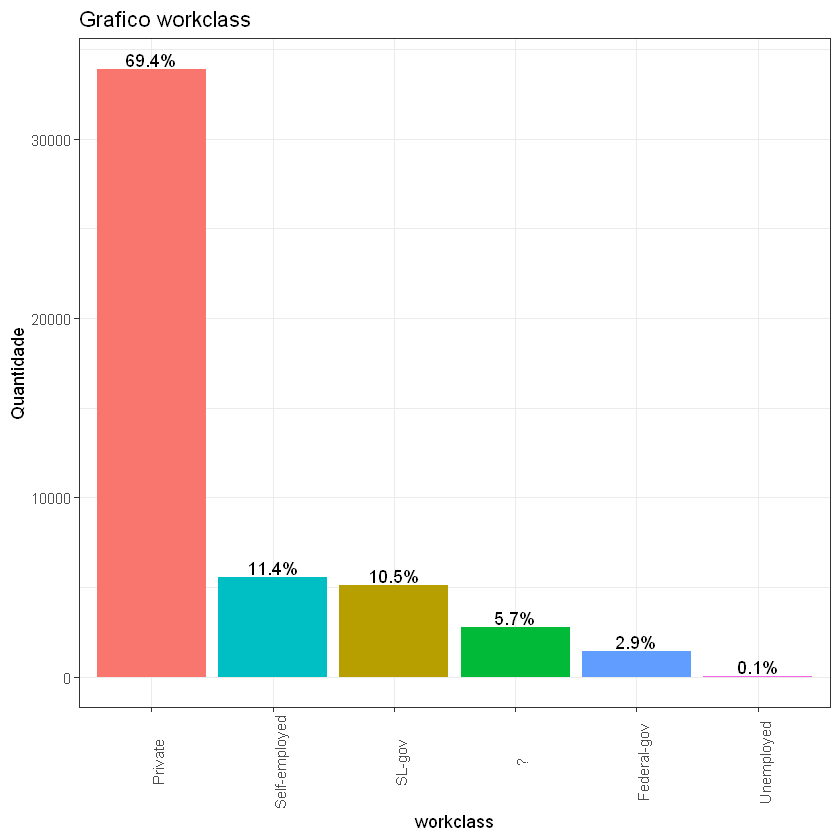

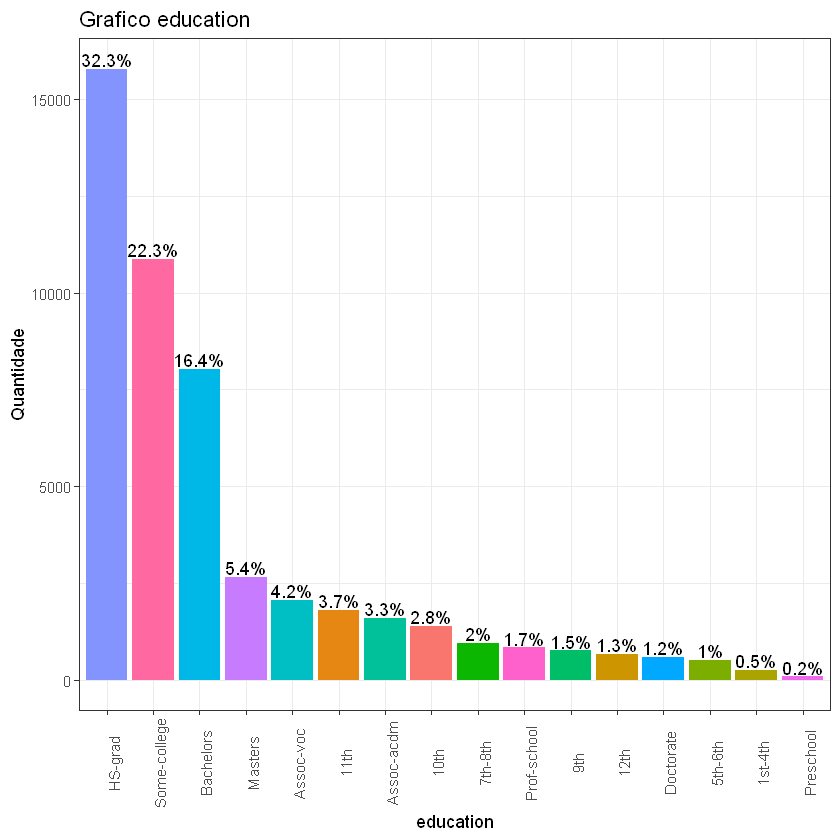

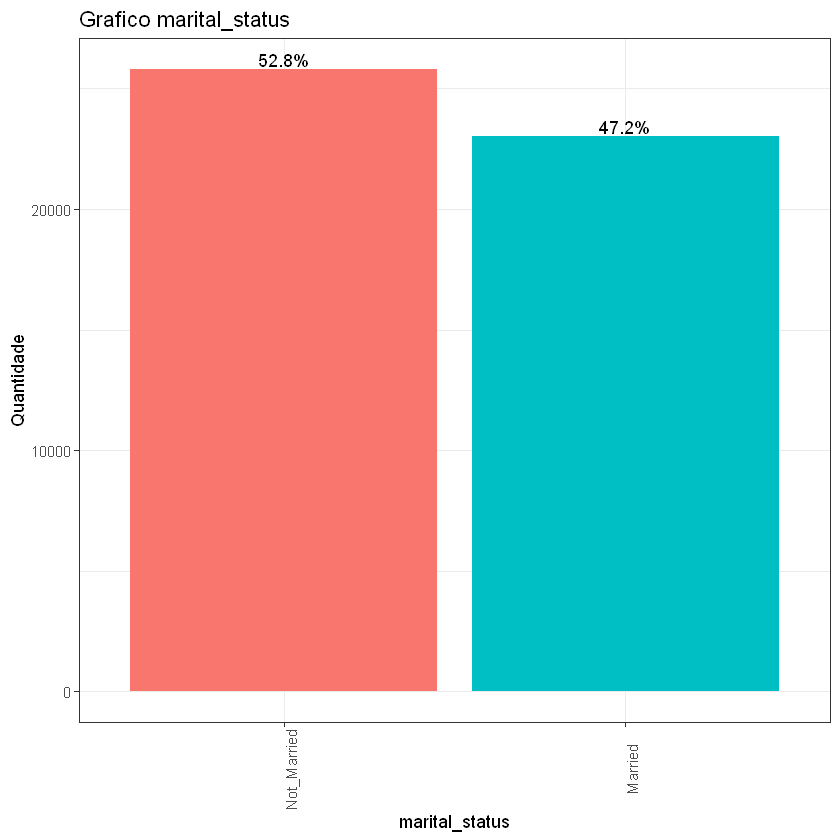

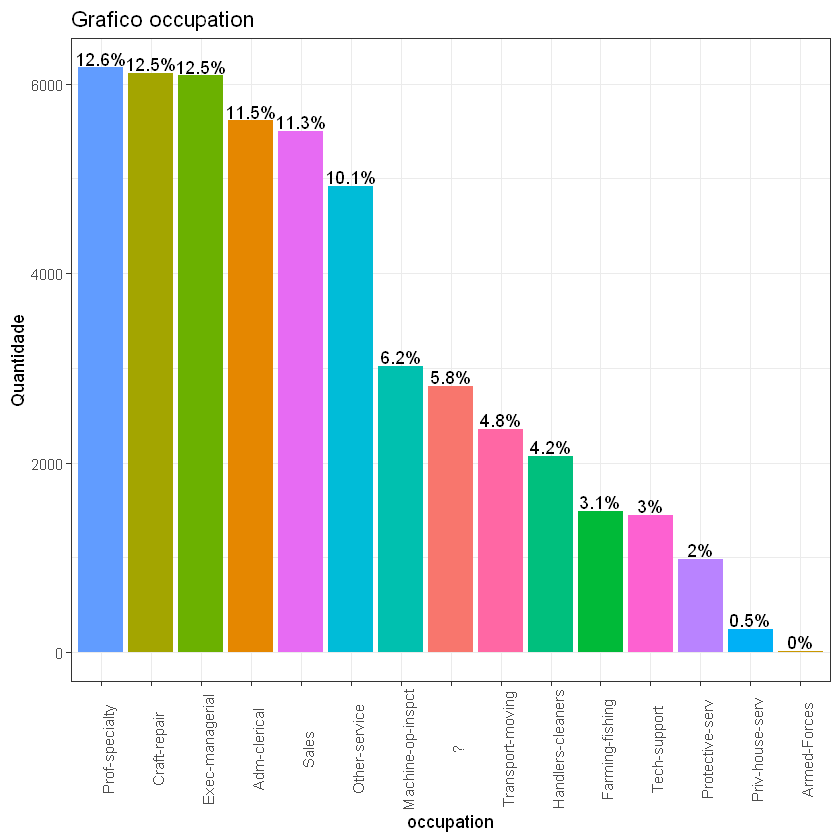

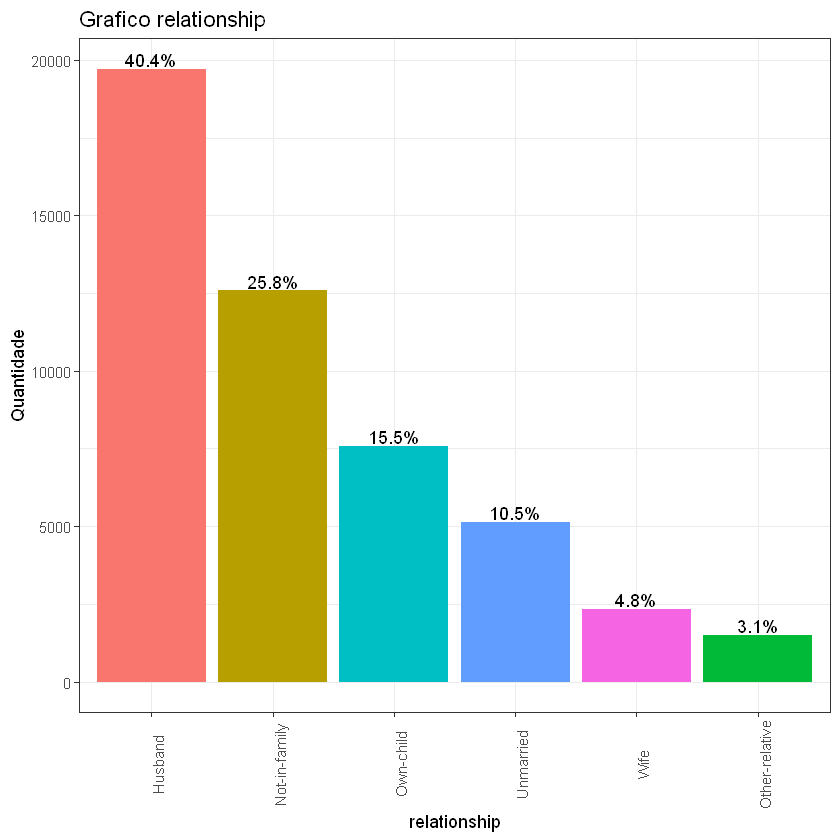

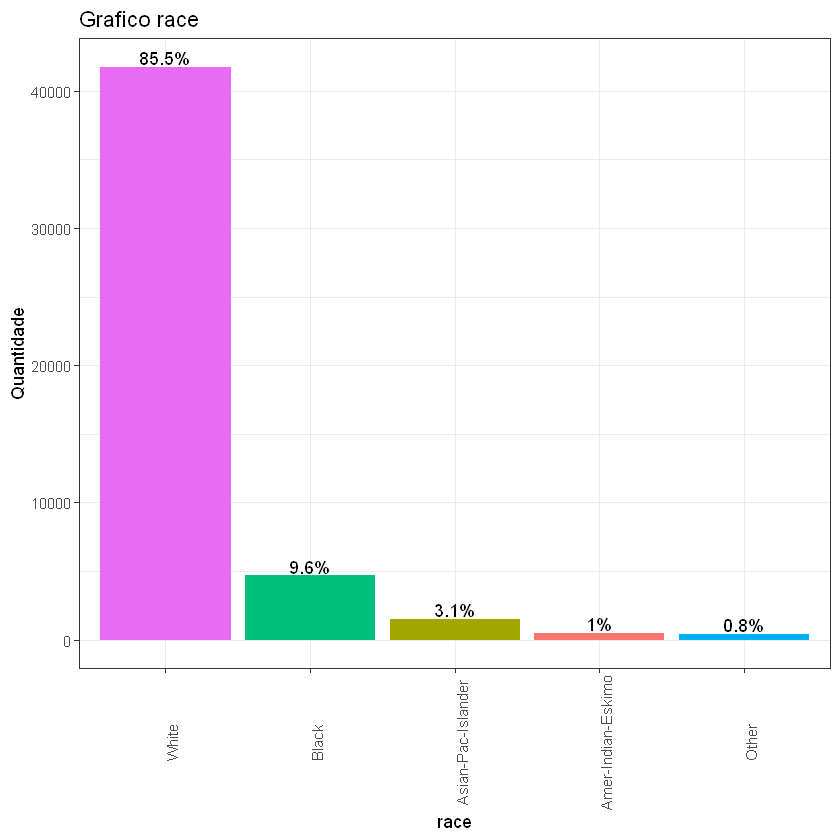

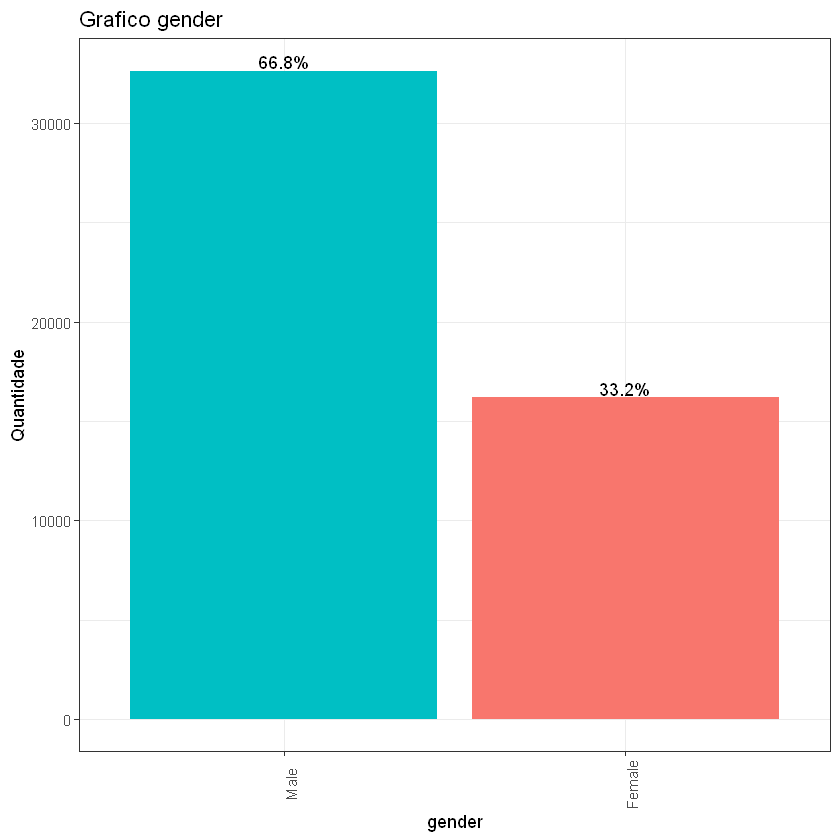

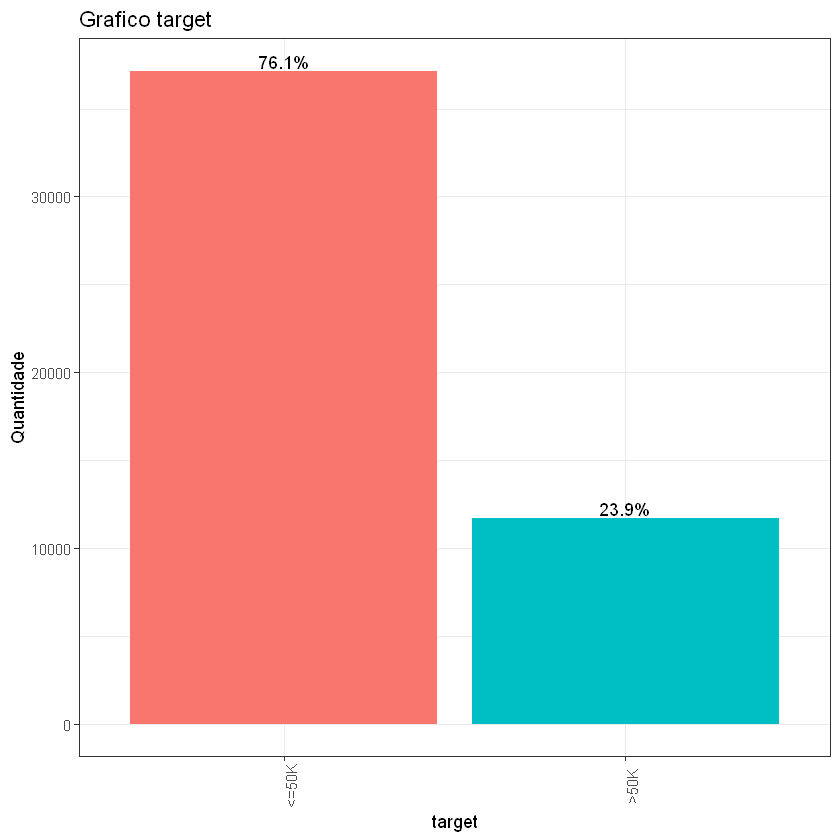

In [24]:
#lista para armazenar gráficos:
lista_grafico = list()


#loop para criar gráfico de barras para as variáveis categóricas:
for (i in 1:length(nomes)){ 
  
  lista_grafico[[i]] = ggplot(df,aes(fct_infreq(!!sym(nomes[i])),fill = !!sym(nomes[i])))+
    geom_bar(stat = "count",show.legend = F)+
    xlab(nomes[i]) + ylab("Quantidade")+ggtitle(paste("Grafico",nomes[i],sep = " "))+
    theme_bw()+
    geom_text(stat = 'count', 
              aes(label = paste0(100*round(stat(count)/nrow(df),digits = 3),"%"),
                  vjust = -0.2))+
    theme(axis.text.x = element_text(angle = 90, vjust = 1))
         
}

for(i in 1:length(nomes)){
    print(lista_grafico[[i]])
}


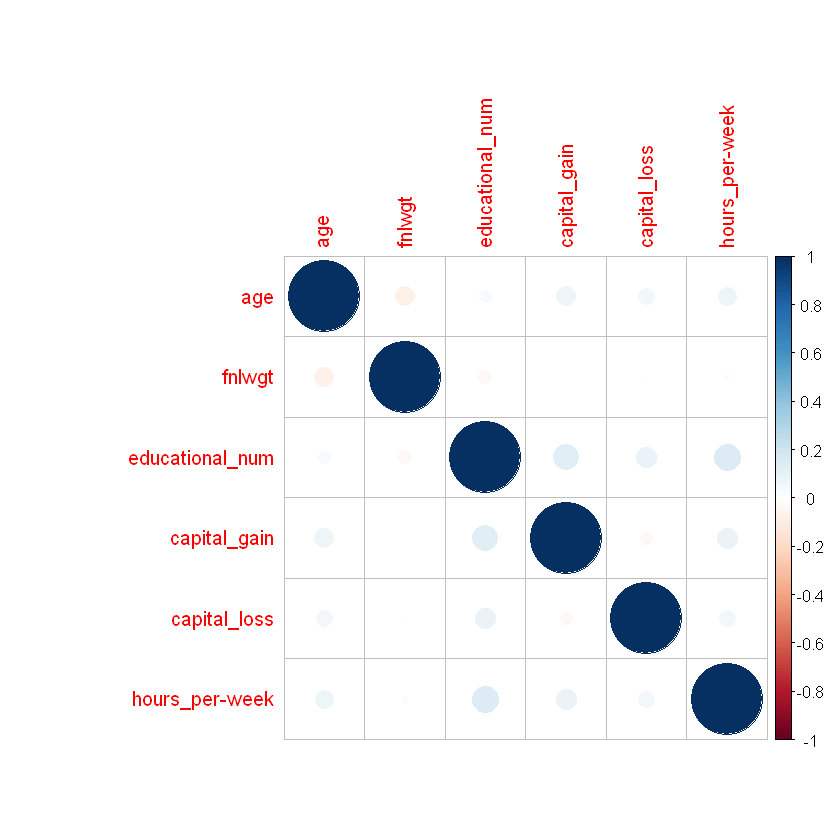

In [25]:
#matriz de correlação:
df_correlacao = df %>% select_if(is.numeric) %>% cor()
corrplot(df_correlacao)

In [26]:
#medidas resumo das variáveis numéricas:
df %>% select_if(is.numeric) %>% summary() %>% kable()



|   |     age      |    fnlwgt      |educational_num | capital_gain | capital_loss  |hours_per-week |
|:--|:-------------|:---------------|:---------------|:-------------|:--------------|:--------------|
|   |Min.   :17.00 |Min.   :  12285 |Min.   : 1.00   |Min.   :    0 |Min.   :   0.0 |Min.   : 1.00  |
|   |1st Qu.:28.00 |1st Qu.: 117551 |1st Qu.: 9.00   |1st Qu.:    0 |1st Qu.:   0.0 |1st Qu.:40.00  |
|   |Median :37.00 |Median : 178145 |Median :10.00   |Median :    0 |Median :   0.0 |Median :40.00  |
|   |Mean   :38.64 |Mean   : 189664 |Mean   :10.08   |Mean   : 1079 |Mean   :  87.5 |Mean   :40.42  |
|   |3rd Qu.:48.00 |3rd Qu.: 237642 |3rd Qu.:12.00   |3rd Qu.:    0 |3rd Qu.:   0.0 |3rd Qu.:45.00  |
|   |Max.   :90.00 |Max.   :1490400 |Max.   :16.00   |Max.   :99999 |Max.   :4356.0 |Max.   :99.00  |

In [28]:

#armazenando p-valor, porém algumas aproximações não foram corretas
#(provavelmente pelo fato de ter menos de cinco em alguma casela da matriz de contagem) 
#nesse caso o teste exato de fisher é conveniente:
df %>%
select_if(is.factor) %>%
summarise_all(funs(chisq.test(.,df$target)$p.value))

Warning message in chisq.test(occupation, df$target):
"Chi-squared approximation may be incorrect"

workclass,education,marital_status,occupation,relationship,race,gender,target
2.217665e-239,0,0,0,0,4.284378e-104,0,0


In [29]:
#separando a base de treino e teste:
intrain = createDataPartition(y = df$target,p = 0.75,list = F)
treino = df[intrain,]
teste = df[-intrain,]
variavel_resposta = teste %>% dplyr::select(target)
teste = teste %>% dplyr::select(-target)

In [ ]:
#criando modelo svm:
modelo_svm = svm(treino$target ~ .,data = treino)

In [ ]:
#realiza a predicao usando o modelo svm:
predicao_svm = predict(modelo_svm,teste)

In [ ]:
#criando matriz de confusão para o modelo svm:
confusionMatrix(variavel_resposta$target,predicao_svm)

In [63]:
#criando modelo de arvore de decisão:
modelo_arvore = rpart::rpart(treino$target ~ .,data = treino)

#predicao modelo arvore:
predicao_arvore = predict(modelo_arvore,teste,type = "class")

In [64]:
#criando matriz de confusão:
confusionMatrix(variavel_resposta$target,predicao_arvore)

Confusion Matrix and Statistics

          Reference
Prediction <=50K >50K
     <=50K  8832  456
     >50K   1424 1497
                                          
               Accuracy : 0.846           
                 95% CI : (0.8395, 0.8524)
    No Information Rate : 0.84            
    P-Value [Acc > NIR] : 0.03623         
                                          
                  Kappa : 0.5228          
 Mcnemar's Test P-Value : < 2e-16         
                                          
            Sensitivity : 0.8612          
            Specificity : 0.7665          
         Pos Pred Value : 0.9509          
         Neg Pred Value : 0.5125          
             Prevalence : 0.8400          
         Detection Rate : 0.7234          
   Detection Prevalence : 0.7608          
      Balanced Accuracy : 0.8138          
                                          
       'Positive' Class : <=50K           
                                          

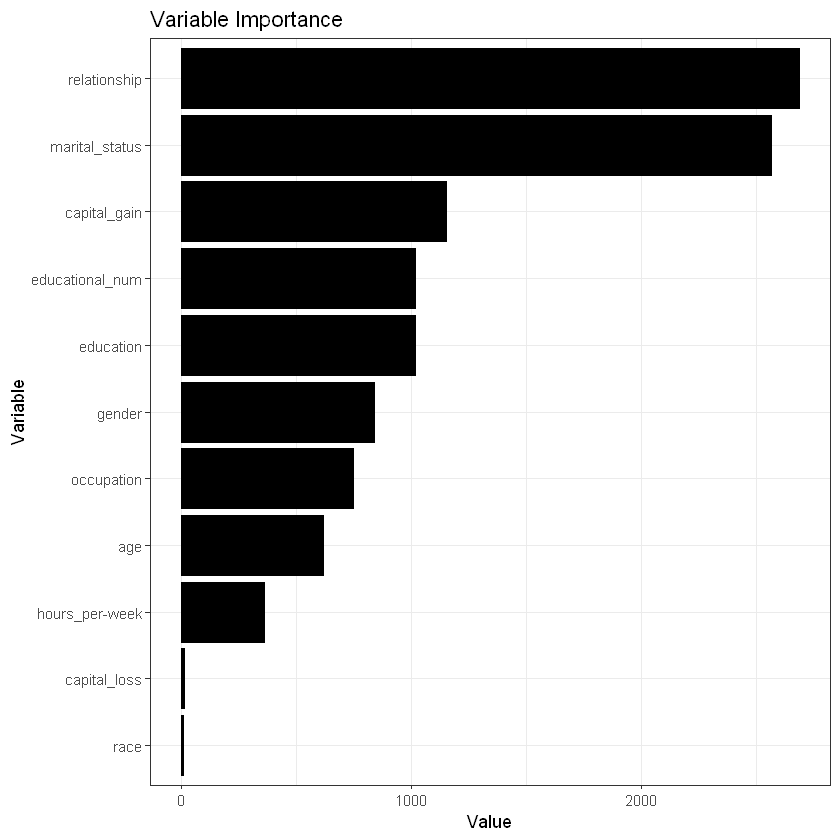

In [67]:
#cria matriz com importancia da variável
matriz_importancia_variavel = rownames_to_column(as_data_frame(modelo_arvore$variable.importance))

#cria gráfico com importancia das variaveis
ggplot(matriz_importancia_variavel,aes(reorder(matriz_importancia_variavel$rowname,matriz_importancia_variavel$value),
                                       matriz_importancia_variavel$value))+
geom_bar(stat = "identity",color = "black",fill = "black")+
coord_flip()+
xlab("Variable")+
ylab("Value")+
theme_bw()+
ggtitle("Variable Importance")